In [1]:
import numpy as np
import matplotlib.pyplot as plt

subjects =  ['sub-EZ9NM','sub-TV7EF','sub-WLC4O','sub-3L109','sub-3UYSS','sub-JVPPA','sub-EDOP8',
             'sub-TIJD1','sub-AYDLR','sub-98UT7','sub-4G9A5','sub-YJBI8','sub-FG8PD','sub-BBN4K',
             'sub-F61IR','sub-M1ZRL','sub-NZJZN','sub-XZ9SS','sub-L05R3','sub-ZOVPY','sub-6PEOF',
             'sub-G6RPG','sub-TPNCU','sub-9ADGJ','sub-27IXQ','sub-NDX5S','sub-OE7EZ','sub-28E84',
             'sub-ENN9N','sub-28OBV','sub-8WJAP','sub-SPHBN','sub-WP8SX','sub-BG4CW','sub-AVQEZ',
             'sub-YLWD1','sub-0A4MV','sub-8PIML','sub-4T7NM','sub-X5RE0','sub-RUQON','sub-JVT46',
             'sub-RTFX9','sub-OWWAF','sub-IC2KG','sub-S3I4J','sub-XFQA1','sub-UKF5L','sub-Z0MJJ',
             'sub-9HMVR','sub-DBQ8H','sub-NAD3W','sub-KH33B','sub-JASQ6','sub-T6FHZ','sub-PQ8JD',
             'sub-NOVID','sub-XAKBX','sub-JVSIQ','sub-D1FKN','sub-R3JA3','sub-GPMCX','sub-H8QL5',
             'sub-6HW3V','sub-WF939']

hippocampal_timeseries = np.load(f'_DATA/hippocampal_timeseries.npy')
cortical_timeseries = np.load(f'_DATA/cortical_timeseries.npy', allow_pickle=True)

content_score = np.load("_DATA/content_score.npy")
ordering_score = np.load("_DATA/ordering_score.npy")

In [3]:
from scipy.linalg import lstsq

BERT_NSP_matrix = np.load('_DATA/BERT_NSP_values.npy')
semantic_similarity_matrix = np.load('_DATA/semantic_similarity_values.npy')

BERT_NSP_matrix_for_plotting = np.mean(BERT_NSP_matrix, axis=0)
BERT_NSP_matrix_for_plotting[np.tril_indices(300)] = np.nan
semantic_similarity_matrix_for_plotting = np.mean(semantic_similarity_matrix, axis=0)
semantic_similarity_matrix_for_plotting[np.tril_indices(300)] = np.nan

# Remove the semantic similarity from BERT NSP values
BERT_NSP_matrix_wo_similarity = np.zeros((3,300,300))
for i in range(3):
    semantic_similarity_vector = semantic_similarity_matrix[i,:,:].reshape(-1,1)
    NSP_vector = BERT_NSP_matrix[i,:,:].reshape(-1,1)

    X = np.concatenate([semantic_similarity_vector, np.ones(semantic_similarity_vector.shape)], axis=1)

    coef, residual, _, _ = lstsq(X, NSP_vector)
    nsp_vector_clean = NSP_vector - X.dot(coef)
    BERT_NSP_matrix_wo_similarity[i,:,:] = nsp_vector_clean.reshape((300,300))

BERT_NSP_matrix_wo_similarity = np.mean(BERT_NSP_matrix_wo_similarity, axis=0)
BERT_NSP_matrix_wo_similarity_for_plotting = np.copy(BERT_NSP_matrix_wo_similarity)
BERT_NSP_matrix_wo_similarity_for_plotting[np.tril_indices(300)] = np.nan
BERT_NSP_matrix_wo_similarity = np.repeat(np.repeat(BERT_NSP_matrix_wo_similarity, 2, axis=0), 2, axis=1)

NSP_matrix = np.repeat(np.repeat(np.mean(BERT_NSP_matrix, axis=0), 2, axis=0), 2, axis=1)
similarity_matrix = np.repeat(np.repeat(np.mean(semantic_similarity_matrix, axis=0), 2, axis=0), 2, axis=1)

NSP_values = np.zeros(600)
semantic_similarity = np.zeros(600)
narrative_coherence = np.zeros(600)
for i in range(1, 600):
    NSP_values[i] = np.max(NSP_matrix[:i,i])
    semantic_similarity[i] = np.max(similarity_matrix[:i,i])
    narrative_coherence[i] = np.max(BERT_NSP_matrix_wo_similarity[:i,i]) #/ (i+1)

from nltools.external import glover_hrf
hrf_weight = glover_hrf(tr=1, oversampling=1)

NSP_values = np.convolve(NSP_values, hrf_weight)[:610]
semantic_similarity = np.convolve(semantic_similarity, hrf_weight)[:610]
narrative_coherence = np.convolve(narrative_coherence, hrf_weight)[:610]

In [4]:
import pickle
from scipy.stats import pearsonr

def get_LLM_sequencing_moments(n, index=narrative_coherence):
    LLM_sequencing_moments = np.zeros(610)
    for i in np.argsort(index)[::-1][:n]:
        LLM_sequencing_moments[i] = 1
    return LLM_sequencing_moments

indices = [NSP_values, semantic_similarity, narrative_coherence]
index_names = ['NSP_value', 'semantic_similarity', 'narrative_coherence']
Schaefer_atlas_parcel = [100,200,300,400,500,600,700,800,900,1000]

save = False
if save:
    for index, name in zip(indices, index_names):
        print(name)
         # Top 10 moments to Top 100 moments
        times = [get_LLM_sequencing_moments(int((i+1)*10), index=index) for i in range(10)]
        hippocampo_cortical_FC = []
        for nr, num_rois in enumerate(Schaefer_atlas_parcel):
            print(num_rois)
            tmp_hippocampo_cortical_FC = np.zeros((len(subjects), num_rois, len(times)))
            for i, fname in enumerate(subjects):
                for t, time in enumerate(times):
                    for r in range(num_rois):
                        tmp_hippocampo_cortical_FC[i,r,t] = pearsonr(hippocampal_timeseries[i,time==1],
                                                                     cortical_timeseries[i,nr][time==1, r])[0]
            hippocampo_cortical_FC.append(tmp_hippocampo_cortical_FC)
        print('done!')

        with open(f'_DATA/hippocampo_cortical_FC_{name}.pkl', 'wb') as f:
            pickle.dump(hippocampo_cortical_FC, f)

In [5]:
from sklearn.linear_model import LinearRegression
from multiprocessing import Pool
selection_threshold = 0.05
def get_LOO_prediction(test_idx):
    test_sub = np.eye(65)[test_idx]==1
    train_subs =  np.eye(65)[test_idx]==0
    positive_edges = []
    negative_edges = []
    for edge in range(num_edges):
        brain_vector = FC[train_subs, edge]
        behav_vector = behavioral_score[train_subs]
        r, p = pearsonr(brain_vector, behav_vector)
        if p < selection_threshold:
            if r >= 0:
                positive_edges.append(edge)
            elif r < 0:
                negative_edges.append(edge)
    positive_edges = np.array(positive_edges)
    negative_edges = np.array(negative_edges)
    if len(positive_edges)>0:
        positive_train = np.sum(FC[train_subs,:][:,positive_edges], axis=1)
        positive_test = np.sum(FC[test_sub,:][:,positive_edges], axis=1)
    else:
        positive_train = np.zeros(64)
        positive_test = np.zeros(1)
    if len(negative_edges)>0:
        negative_train = np.sum(FC[train_subs,:][:,negative_edges], axis=1)
        negative_test = np.sum(FC[test_sub,:][:,negative_edges], axis=1)
    else:
        negative_train = np.zeros(64)
        negative_test = np.zeros(1)
    X_train = np.vstack([positive_train, negative_train]).T
    X_test = np.vstack([positive_test, negative_test]).T
    y_train = behavioral_score[train_subs]
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)[0]
    return y_pred

save = False
if save:
    for index, name in zip(indices, index_names):
        print(name)
        times = [get_LLM_sequencing_moments(int((i+1)*10), index=index) for i in range(10)]
        with open(f'_DATA/hippocampo_cortical_FC_{name}.pkl', 'rb') as f:
            hippocampo_cortical_FC = pickle.load(f)

        model_predictivity = np.zeros((len(Schaefer_atlas_parcel), 2, len(times)))
        for nr, num_rois in enumerate(Schaefer_atlas_parcel):
            num_edges = num_rois
            for b, behavioral_score in enumerate([ordering_score, content_score]):
                predictivity_r = []
                for t, time in enumerate(times):
                    FC  = hippocampo_cortical_FC[nr][:,:,t]
                    FC = np.arctanh(FC)
                    with Pool() as pool:
                        behavioral_prediction = pool.map(get_LOO_prediction, [i for i in np.arange(len(subjects))])
                    r, p = pearsonr(behavioral_prediction, behavioral_score)
                    predictivity_r.append(r)
                    model_predictivity[nr, b, t] = r
        np.save(f'_DATA/hippocampo_cortical_model_predictivity_{name}.npy', model_predictivity)

(-0.58, 0.58)

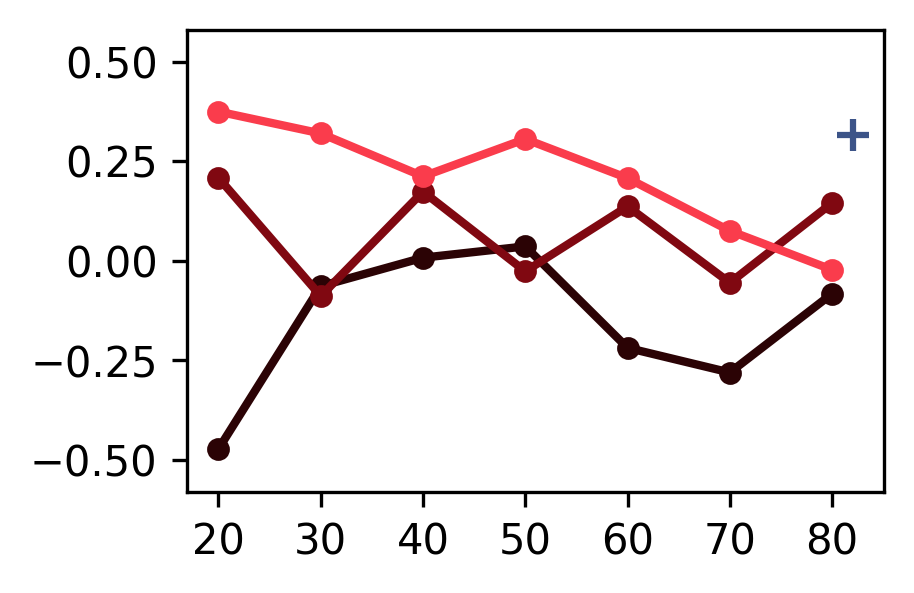

In [6]:
predictivity_original = np.load('_DATA/hippocampo_cortical_model_predictivity.npy')

index_names = ['NSP_value', 'semantic_similarity', 'narrative_coherence']
predictivity_LLMs = [np.load(f'_DATA/hippocampo_cortical_model_predictivity_{name}.npy')
                     for name in index_names]

plt.style.use('default')
plt.figure(figsize=(3,2), dpi=300)
plt.plot(predictivity_LLMs[2][1,0,1:8], c='#fa3c4c', lw=2, zorder=100)
plt.scatter([0,1,2,3,4,5,6], predictivity_LLMs[2][1,0,1:8], c='#fa3c4c', s=20, zorder=100)
plt.plot(predictivity_LLMs[0][1,0,1:8], c='#800811', lw=2, zorder=30)
plt.scatter([0,1,2,3,4,5,6], predictivity_LLMs[0][1,0,1:8], c='#800811', s=20, zorder=30)
plt.plot(predictivity_LLMs[1][1,0,1:8], c='#2b0305', lw=2, zorder=10)
plt.scatter([0,1,2,3,4,5,6], predictivity_LLMs[1][1,0,1:8], c='#2b0305', s=20, zorder=10)

plt.scatter([6.2], [predictivity_original[1,0,2]], s=60, c='#3C5488', zorder=200, marker='+')

plt.xticks([0,1,2,3,4,5,6], [20,30,40,50,60,70,80])
plt.ylim(-0.58, 0.58)

Ordering score vs. hippocampus-vmPFC at LLM-generated sequencing moments
PearsonRResult(statistic=-0.3014719808585782, pvalue=0.014668752113020992)


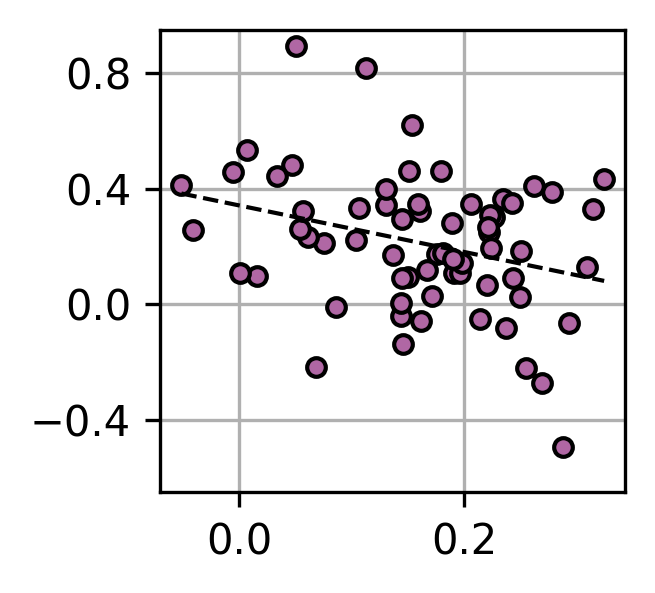

In [8]:
from scipy.stats import linregress

with open(f'_DATA/hippocampo_cortical_FC_narrative_coherence.pkl', 'rb') as f:
    hippocampo_cortical_FC = pickle.load(f)

print('Ordering score vs. hippocampus-vmPFC at LLM-generated sequencing moments')

atlas_idx = 1
num_rois = 200
num_edges = num_rois

roi = 191 -1
plt.style.use('default')
plt.figure(figsize=(2,2), dpi=300)
y = hippocampo_cortical_FC[atlas_idx][:,roi, 4] # 1:Top20, 4:Top50
y = np.arctanh(y)
x = ordering_score
plt.scatter(x, y, s=20, c='#B067A4', edgecolors='k', zorder=100)
slope, intercept, r, p, stderr = linregress(x, y)
x_range = np.array([np.min(x), np.max(x)])
plt.plot(x_range, intercept + slope * x_range, 'k--', label='r={:0.3f}, p={:0.3f}'.format(r, p),
         zorder=100, lw=1)
plt.grid(True, zorder=0)
plt.yticks([-0.4, 0.0, 0.4, 0.8])
plt.xticks([0, 0.2])
plt.ylim(-0.65, 0.95)
print(pearsonr(x, y))

Content score vs. hippocampus-vmPFC at LLM-generated sequencing moments
PearsonRResult(statistic=-0.1041097816937571, pvalue=0.40919008857299244)


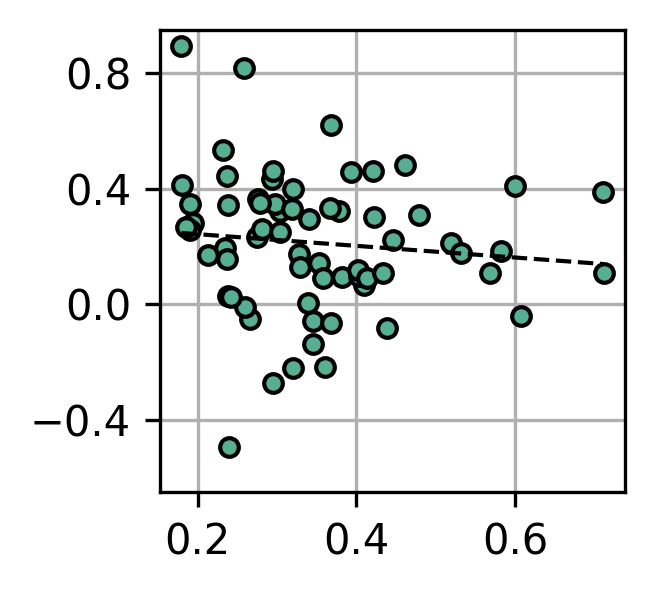

In [10]:

print('Content score vs. hippocampus-vmPFC at LLM-generated sequencing moments')

atlas_idx = 1
num_rois = 200
num_edges = num_rois

roi = 191 -1
plt.style.use('default')
plt.figure(figsize=(2,2), dpi=300)
y = hippocampo_cortical_FC[atlas_idx][:,roi, 4] # 1:Top20, 4:Top50
y = np.arctanh(y)
x = content_score
plt.scatter(x, y, s=20, c='#56AE93', edgecolors='k', zorder=100)
slope, intercept, r, p, stderr = linregress(x, y)
x_range = np.array([np.min(x), np.max(x)])
plt.plot(x_range, intercept + slope * x_range, 'k--', label='r={:0.3f}, p={:0.3f}'.format(r, p),
         zorder=100, lw=1)
plt.grid(True, zorder=0)
plt.yticks([-0.4, 0.0, 0.4, 0.8])
plt.xticks([0.2, 0.4, 0.6])
plt.ylim(-0.65, 0.95)
print(pearsonr(x, y))

In [11]:
# Proportion of edge selection

from multiprocessing import Pool
import pickle

selection_threshold = 0.05
def get_LOO_prediction_edges(test_idx):
    test_sub = np.eye(65)[test_idx]==1
    train_subs =  np.eye(65)[test_idx]==0
    positive_edges = []
    negative_edges = []
    for edge in range(num_edges):
        brain_vector = FC[train_subs, edge]
        behav_vector = behavioral_score[train_subs]
        r, p = pearsonr(brain_vector, behav_vector)
        if p < selection_threshold:
            if r >= 0:
                positive_edges.append(edge)
            elif r < 0:
                negative_edges.append(edge)
    positive_edges = np.array(positive_edges)
    negative_edges = np.array(negative_edges)
    return [positive_edges, negative_edges]

save = False
if save:
    with open(f'_DATA/hippocampo_cortical_FC_narrative_coherence.pkl', 'rb') as f:
        hippocampo_cortical_FC = pickle.load(f)

    scheafer_index = [0,1,2,3,4]
    for i in scheafer_index:
        num_rois = Schaefer_atlas_parcel[i]
        num_edges = num_rois
        model_edges = np.zeros(2, dtype='object')
        for b, behavioral_score in enumerate([ordering_score, content_score]):
            FC  = hippocampo_cortical_FC[scheafer_index][:,:,4]
            FC  = np.arctanh(FC)
            with Pool() as pool:
                edges = pool.map(get_LOO_prediction_edges, [i for i in np.arange(len(subjects))])
            model_edges[b] = edges

        model_positive_edges = np.zeros((2,num_rois))
        model_negative_edges = np.zeros((2,num_rois))
        for b, behavioral_score in enumerate([ordering_score, content_score]):
            for s, subject in enumerate(subjects):
                if len(model_edges[b][s][0]) > 0:
                    model_positive_edges[b,model_edges[b][s][0]] += 1
                if len(model_edges[b][s][1]) > 0:
                    model_negative_edges[b,model_edges[b][s][1]] += 1
        model_positive_edges /= len(subjects)
        model_negative_edges /= len(subjects)

        np.save(f'_DATA/selected_edges/LLM_generated_model_positive_edges_{num_rois}.npy', model_positive_edges)
        np.save(f'_DATA/selected_edges/LLM_generated_model_negative_edges_{num_rois}.npy', model_negative_edges)

Started server on port 2002
{'camera.azimuth': 0, 'camera.altitude': 90, 'camera.target': [0, 0, 0], 'surface.{subject}.unfold': 1.0, 'surface.{subject}.pivot': 180, 'surface.{subject}.shift': 10, 'surface.{subject}.specularity': 0, 'surface.{subject}.sampler': 'nearest', 'surface.{subject}.layers': 1}
{'camera.azimuth': 180, 'camera.altitude': 90, 'camera.target': [0, 0, 0], 'surface.{subject}.unfold': 1.0, 'surface.{subject}.pivot': 180, 'surface.{subject}.shift': 10, 'surface.{subject}.specularity': 0, 'surface.{subject}.sampler': 'nearest', 'surface.{subject}.layers': 1}
Stopping server
Stopping server


/tmp/ipykernel_1758931/2051900421.py:49: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.


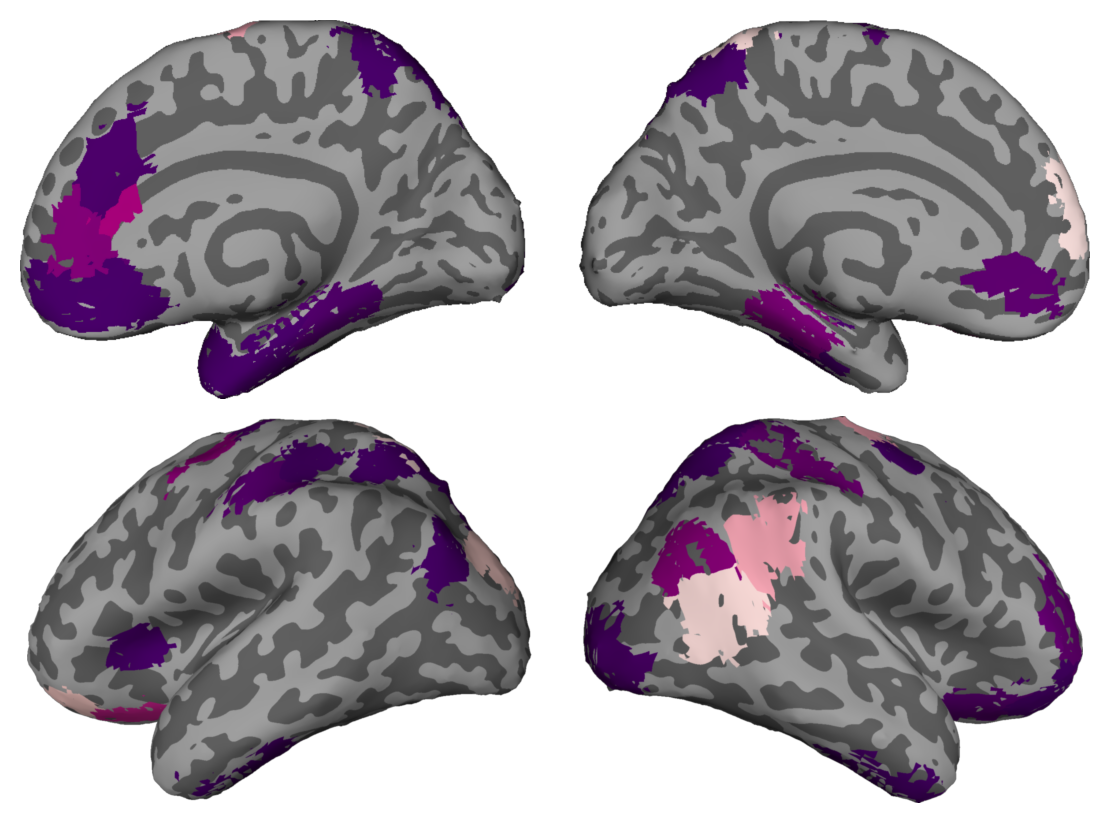

In [12]:
# IMPORTANT NOTE: Running this cell will restart the jupyter kernel,
#                 due to the use of the figure export in pycortex package
#                 Please run this cell in a separate jupyter notebook

import os
import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cortex
base_name = os.path.join(tempfile.mkdtemp(), 'fig')

num_rois = 200
Schaefer_atlas = nib.load(f"utils/brain_atlas/Schaefer2018_cortical_{num_rois}_3mm.nii.gz").get_fdata()
model_positive_edges = np.load(f'_DATA/selected_edges/LLM_generated_model_positive_edges_{num_rois}.npy')
model_negative_edges = np.load(f'_DATA/selected_edges/LLM_generated_model_negative_edges_{num_rois}.npy')

r_statmap = np.zeros(Schaefer_atlas.shape)
for r in range(num_rois):
    r_1 = np.max([model_positive_edges[0,r], model_negative_edges[0,r]])
    if r_1>0.1:
        r_statmap[Schaefer_atlas==r+1] = r_1
r_statmap[r_statmap<0.1] = np.nan

cmax = 1.0
cmin = 0.0

cmap = 'RdPu'
cmap_label = 'Edge selection'
vol_data = cortex.Volume(r_statmap.transpose(2,1,0), 'MNI152', 'fmriprep',
                         cmap=cmap, colorbar=True, vmax=cmax, vmin=cmin)

filenames = cortex.export.save_3d_views(
                vol_data, base_name=base_name,
                list_angles=['medial_pivot', 'lateral_pivot'], #medial_pivot or lateral_pivot
                list_surfaces=['inflated', 'inflated'],
                size=(1024 * 4, 768 * 2), trim=True,)

fig = plt.figure(constrained_layout=True, dpi=200, figsize=(6,4))
gs = fig.add_gridspec(2, 1, height_ratios=[4.95, 5.05])

ax1 = fig.add_subplot(gs[0])
ax1.imshow(plt.imread(filenames[0]), interpolation='gaussian')
ax1.axis('off')

ax2 = fig.add_subplot(gs[1])
ax2.imshow(plt.imread(filenames[1]), interpolation='gaussian')
ax2.axis('off')
plt.subplots_adjust(hspace=0.01)